In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time, sys
from IPython.core.display import display
from IPython.core.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
### The Ackley Function
def ackley2d(x, y, a=20, b=0.2, c=2*np.pi):
    d = 2
    sum1 = x**2 + y**2
    sum2 = np.cos(c*x) + np.cos(c*y)
    term1 = -a * np.exp(-b*np.sqrt(sum1/d))
    term2 = -np.exp(sum2/d)
    s = term1 + term2 + a + np.exp(1)
    return(s)

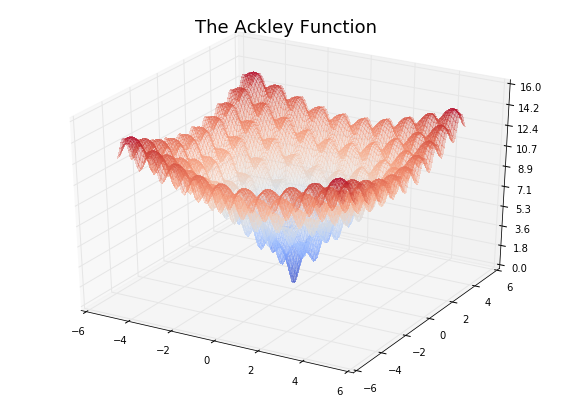

In [4]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
x = np.linspace(-5, 5, 100)
y = x
X,Y = np.meshgrid(x, y)
Z = ackley2d(X, Y)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False, alpha=.3)

#ax.set_zlim(0, 0.2)

ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.01f'))
ax.set_title('The Ackley Function', fontsize=18)

plt.show()

In [6]:
### searching for minimum with simplex

from scipy.optimize import minimize

x0 = (-4,4)
res = minimize(ackley2d, *x0, method='nelder-mead', options={'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 11.005881
         Iterations: 12
         Function evaluations: 24
[-3.98320313]


### (simplified) Differential Evolution

Require inputs:
parameter bound, objective function, size of population, life time of population

1. Initialize first generation within parameter bounds, and evaluate with objective function.
2. For each individual, select another two individuals and take the difference, add this difference to create offspring.
3. Evaluate offsprings, and substitute parents with better offsprings.
4. Repeat step 2-3 untill life time.

In [7]:
class population(object):
    
    ### initialize population
    def __init__(self, bounds, size, life, func):
        self.func, self.size, self.life = func, size, life
        
        self.low_bound = np.tile(bounds[0], (size,1))
        self.upp_bound = np.tile(bounds[1], (size,1))
        
        ### set generation to 1
        self.generation = 1
        
        ### initialize individuals for generation 1
        self.individuals = (np.random.random((size, self.low_bound.shape[1]))
                            *(self.upp_bound-self.low_bound)+self.low_bound)
        ### evaluate with objective function
        self.fitness = self.evaluate(self.individuals)
    
    ### evolve generation
    def evolve(self):
        gamma = .8
        
        ## randomly select two individuals for each individual
        parents = np.array([np.random.choice(self.size-2,2) for _ in range(self.size)])
        parents = np.mod(parents+np.arange(self.size).reshape(self.size,1), self.size)
        
        ## take the difference, add this difference to create offspring
        offsprings = self.individuals + gamma*(self.individuals[parents[:,0],:] - self.individuals[parents[:,1],:])
        offsprings = self.bound_handle(offsprings)
        
        fitness  = self.evaluate(offsprings)
        
        keep = fitness<self.fitness
        self.individuals[keep] = offsprings[keep]
        self.fitness[keep] = fitness[keep]
        
        self.generation += 1
        return self
    
    def plot(self):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.gca(projection='3d')
        x = np.linspace(self.low_bound[0,0], self.upp_bound[0,0], 100)
        y = np.linspace(self.low_bound[0,1], self.upp_bound[0,1], 100)
        X,Y = np.meshgrid(x, y)
        Z = self.func(X, Y)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
                linewidth=0, antialiased=False, alpha=.3)
        ax.zaxis.set_major_locator(plt.LinearLocator(10))
        ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.01f'))

        for i in range(self.life):
            if np.mod(i,10) == 0:
                try:
                    patch.remove()
                except UnboundLocalError:
                    pass
                self = self.evolve()
                patch = ax.scatter(self.individuals[:,0], self.individuals[:,1], 
                                   self.fitness, s=50, marker='*', color='k')
                time.sleep(0.1)
                display(fig)
                clear_output(wait=True)
        
        final_fit = self.fitness.min()
        final_para = self.individuals[self.fitness==final_fit,:].flatten()
        ax.set_title('Optimized parameters: '+','.join(["{:.3}".format(para) for para in final_para]))

    ####### utility functions   
    
    ### evaluate each individual
    def evaluate(self, individuals):
        return self.func(*[cln for cln in individuals.T])
    
    ### making sure individuals are in-bound
    def bound_handle(self, inds):
        lows = inds<self.low_bound
        higs = inds>self.upp_bound
        inds_new = inds.copy()      
        if lows.any()|higs.any():
            inds_new[lows] = 2*self.low_bound[lows] - inds[lows]
            inds_new[higs] = 2*self.upp_bound[higs] - inds[higs]
            inds_new = self.bound_handle(inds_new)
        return inds_new

In [8]:
bounds = [[-4,-4],[4,4]]
size = 100
life = 300
func = ackley2d

ackley_evolve = population(bounds, size, life, func)

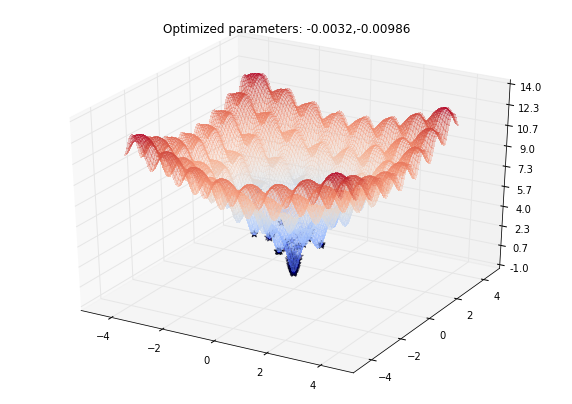

In [9]:
ackley_evolve.plot()